In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

In [75]:
file_path = "E:\Поиск работы\Портфолио\AB test\datasets"
files = os.listdir(file_path)

In [76]:
data_types = {
    'userid': 'str',
    'retention_1': 'int',
    'retention_7': 'int'
}

df = (pd.read_csv(file_path + '/' + files[0]).astype(data_types))

In [77]:
# get rid of player who passed 49 854 levels
control_group_30 = df.copy()[(df['version'] == "gate_30") & (df['sum_gamerounds'] != max(df['sum_gamerounds']))].drop(columns="version")
test_group_40 = df.copy()[df['version'] == "gate_40"].drop(columns="version")

In [78]:
test_group_less_29 = test_group_40[test_group_40['sum_gamerounds'] < 29]
control_group_less_29 = control_group_30[control_group_30['sum_gamerounds'] < 29]

test_group_29_100 = test_group_40[(test_group_40['sum_gamerounds'] >= 29) & (test_group_40['sum_gamerounds'] <= 100)]
control_group_29_100 = control_group_30[(control_group_30['sum_gamerounds'] >= 29) & (control_group_30['sum_gamerounds'] <= 100)]

test_group_more_100 = test_group_40[test_group_40['sum_gamerounds'] > 100]
control_group_more_100 = control_group_30[control_group_30['sum_gamerounds'] > 100]

In [79]:
def generate_subsamples(n: int, b: int, test_group: pd.Series, control_group: pd.Series):
    bootstrap_test_group = np.random.choice(test_group, (b, n), True)
    bootstrap_control_group = np.random.choice(control_group, (b, n), True)
    return bootstrap_test_group, bootstrap_control_group

In [80]:
def bootstrap_quantile_fucn(quantile: float, test_group: pd.Series, control_group: pd.Series, bootstrap_test_group: np.array, bootstrap_control_group: np.array, alpha=0.05):
    pe = np.quantile(test_group, quantile) - np.quantile(control_group, quantile)
    pe_ptc = pe/np.quantile(control_group, quantile) * 100
    bootstrap_test_group_metric = np.quantile(bootstrap_test_group, quantile, axis=1)
    bootstrap_control_group_metric = np.quantile(bootstrap_control_group, quantile, axis=1)

    bootstrap_stats = bootstrap_test_group_metric - bootstrap_control_group_metric
    ci = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    ci_left_ptc = ci[0] / np.quantile(control_group, quantile) * 100
    ci_right_ptc = ci[1] / np.quantile(control_group, quantile) * 100
    has_effect = not (ci[0] < 0 < ci[1])

    print(f'Value of {quantile*100:.0f}% quntile changed by: {pe:0.4f} ({pe_ptc:0.4f}%)\n'
          f'{((1 - alpha) * 100)}% confidence interval: ({ci[0]:0.4f}, {ci[1]:0.4f}) или ({ci_left_ptc:0.4f}%, {ci_right_ptc:0.4f}%)\n'
          f'The difference is statistically significant: {has_effect}')

    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    sns.kdeplot(bootstrap_control_group_metric, label='Control group', ax=axes[0]);
    sns.kdeplot(bootstrap_test_group_metric, color='red', label='Test group', ax=axes[0]);
    axes[0].legend()

    sns.kdeplot(bootstrap_stats,label='Difference', ax=axes[1])
    for _ in ci:
        axes[1].axvline(_, color='red')
    axes[1].legend()
    plt.show()

In [81]:
def bootstrap_mean_fucn(test_group: pd.Series, control_group: pd.Series, bootstrap_test_group: np.array, bootstrap_control_group: np.array, alpha=0.05):
    pe = np.mean(test_group) - np.mean(control_group)
    pe_ptc = pe/np.mean(control_group) * 100

    bootstrap_test_group_mean = np.mean(bootstrap_test_group, axis=1)
    bootstrap_control_group_mean = np.mean(bootstrap_control_group, axis=1)

    bootstrap_stats_mean = bootstrap_test_group_mean - bootstrap_control_group_mean

    z = stats.norm.ppf(1 - alpha/2)
    se = np.std(bootstrap_stats_mean)
    ci = pe - z * se, pe + z * se
    ci_left_ptc = ci[0] / np.mean(control_group) * 100
    ci_right_ptc = ci[1] / np.mean(control_group) * 100
    has_effect = not (ci[0] < 0 < ci[1])
    print(f'Value of metric changed by: {pe:0.4f} ({pe_ptc:0.4f} %)\n'
          f'{((1 - alpha) * 100)}% confidence interval: ({ci[0]:0.4f}, {ci[1]:0.4f}) или ({ci_left_ptc:0.4f}%, {ci_right_ptc:0.4f}%)\n'
          f'The difference is statistically significant: {has_effect}')

    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    sns.kdeplot(bootstrap_control_group_mean, label='Control group', ax=axes[0])
    sns.kdeplot(bootstrap_test_group_mean, color='red',label='Test group', ax=axes[0])
    axes[0].legend()

    sns.kdeplot(bootstrap_stats_mean,label='Difference', ax=axes[1])
    for _ in ci:
        axes[1].axvline(_, color='red')
    axes[1].legend()
    plt.show()

In [82]:
n = round(min(len(test_group_40), len(control_group_30))-500, -3)
b = 10000

bootstrap_test_group_40, bootstrap_control_group_30 = generate_subsamples(n, b, test_group_40['sum_gamerounds'], control_group_30['sum_gamerounds'])

Value of 50% quntile changed by: -1.0000 (-5.8824%)
95.0% confidence interval: (-1.0000, 0.0000) или (-5.8824%, 0.0000%)
The difference is statistically significant: True


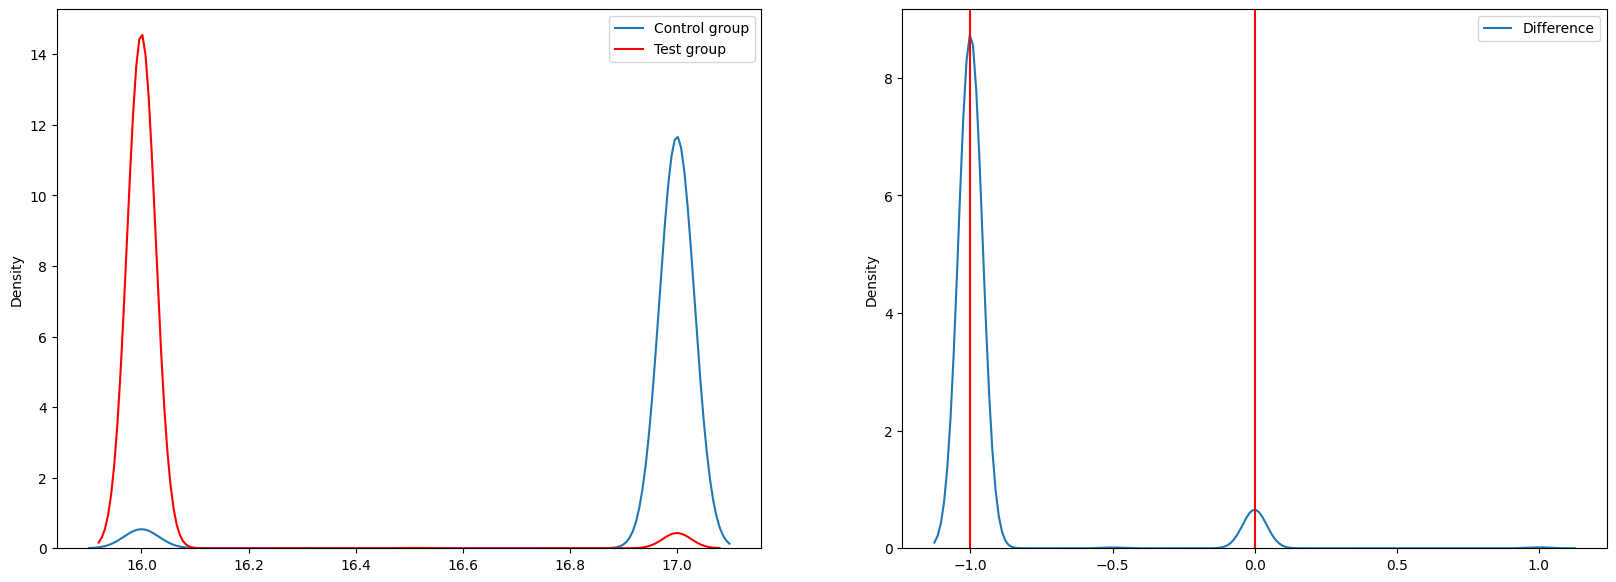

In [83]:
quantile = 0.5
bootstrap_quantile_fucn(
    quantile,
    test_group_40['sum_gamerounds'],
    control_group_30['sum_gamerounds'],
    bootstrap_test_group_40,
    bootstrap_control_group_30
)

Value of 75% quntile changed by: 2.0000 (4.0000%)
95.0% confidence interval: (0.0000, 3.0000) или (0.0000%, 6.0000%)
The difference is statistically significant: True


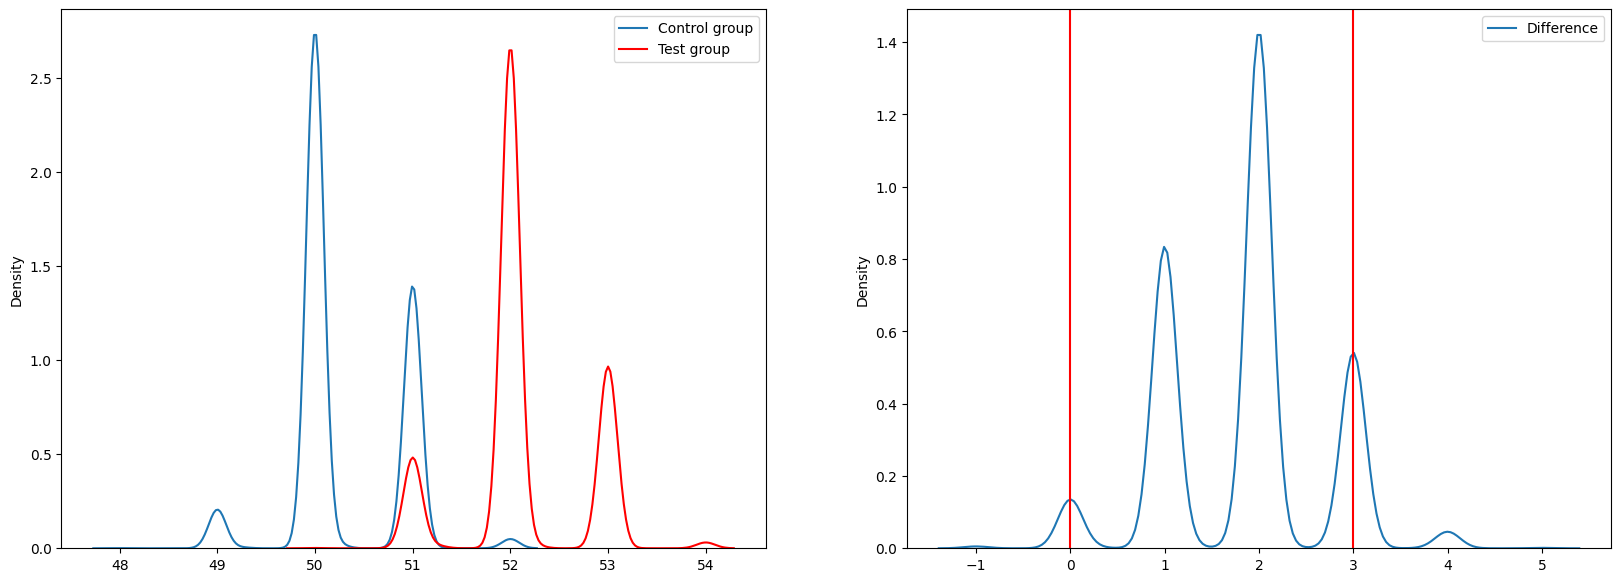

In [84]:
quantile = 0.75
bootstrap_quantile_fucn(
    quantile,
    test_group_40['sum_gamerounds'],
    control_group_30['sum_gamerounds'],
    bootstrap_test_group_40,
    bootstrap_control_group_30
)

Value of metric changed by: -0.0433 (-0.0844 %)
95.0% confidence interval: (-1.3935, 1.3069) или (-2.7142%, 2.5454%)
The difference is statistically significant: False


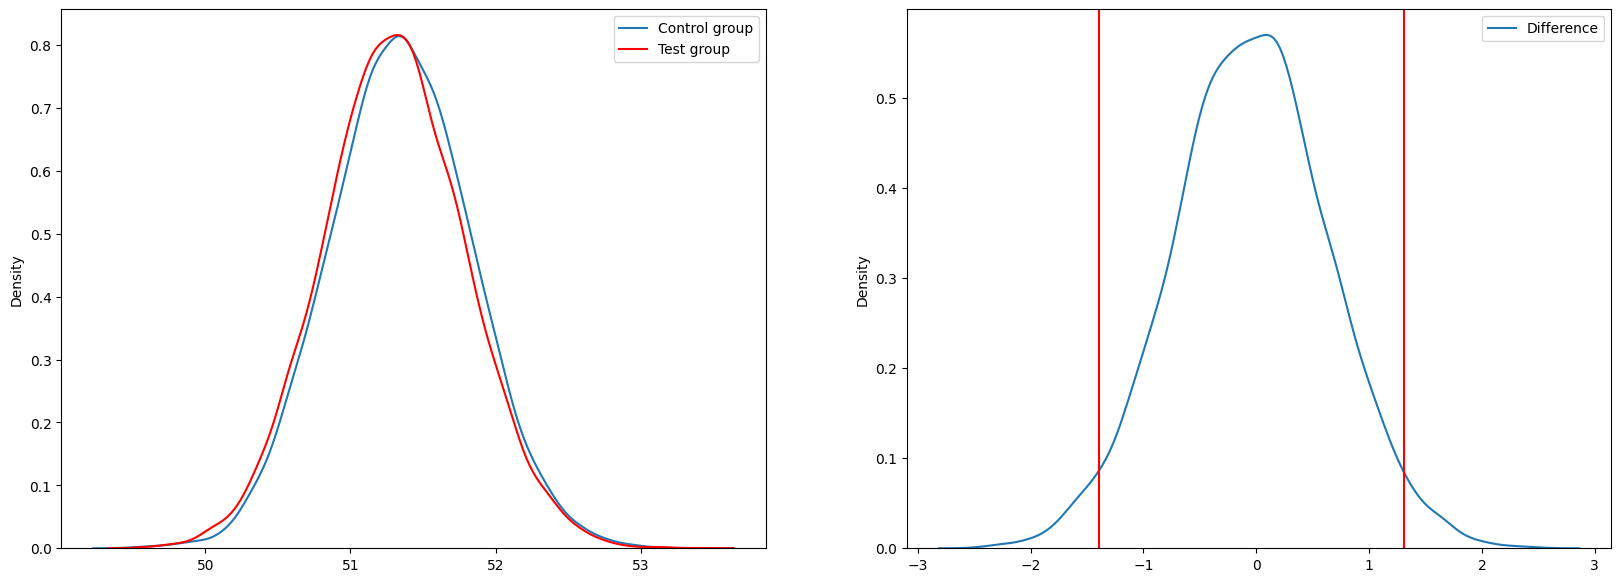

In [85]:
bootstrap_mean_fucn(
    test_group_40['sum_gamerounds'],
    control_group_30['sum_gamerounds'],
    bootstrap_test_group_40,
    bootstrap_control_group_30
)

Value of metric changed by: -0.0059 (-1.3198 %)
95.0% confidence interval: (-0.0124, 0.0006) или (-2.7696%, 0.1300%)
The difference is statistically significant: False


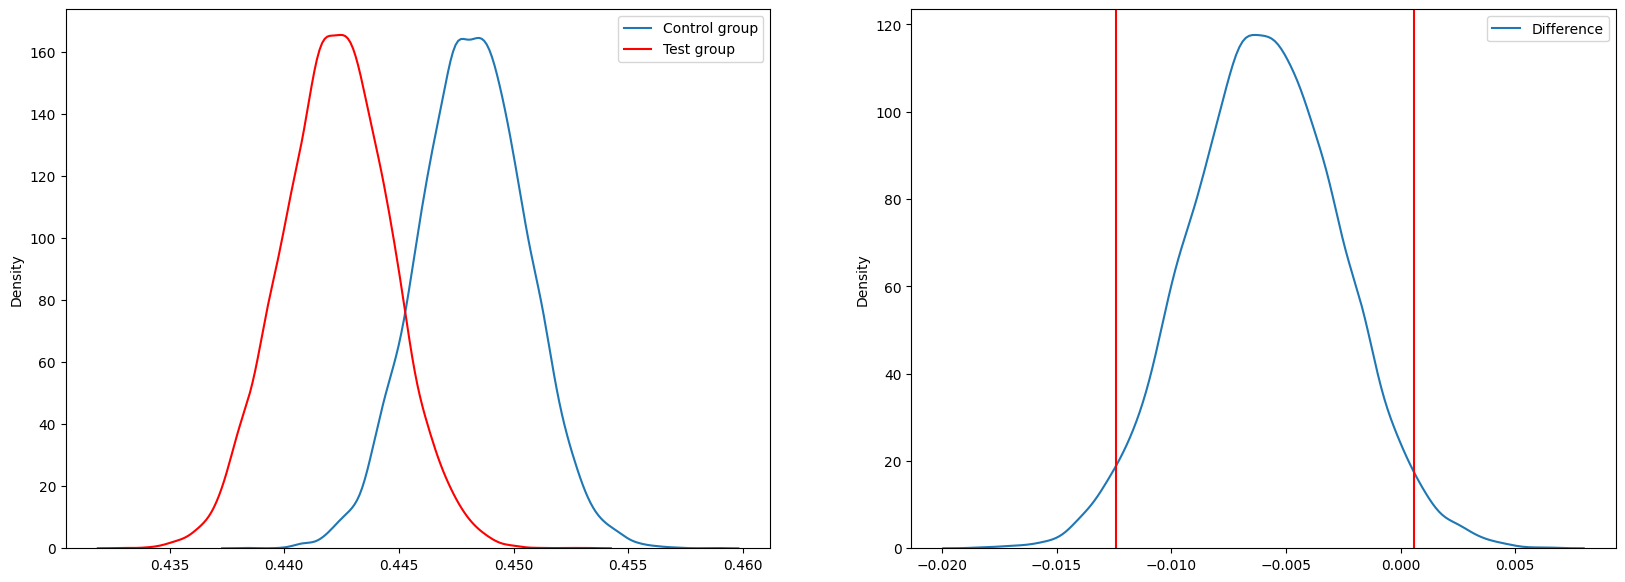

In [86]:
n = round(min(len(test_group_40), len(control_group_30))-500, -3)
b = 10000

bootstrap_test_group_40_rr1, bootstrap_control_group_30_rr1 = generate_subsamples(n, b, test_group_40['retention_1'], control_group_30['retention_1'])

bootstrap_mean_fucn(
    test_group_40['retention_1'],
    control_group_30['retention_1'],
    bootstrap_test_group_40_rr1,
    bootstrap_control_group_30_rr1
)

Value of metric changed by: -0.0082 (-4.3028 %)
95.0% confidence interval: (-0.0133, -0.0031) или (-6.9865%, -1.6190%)
The difference is statistically significant: True


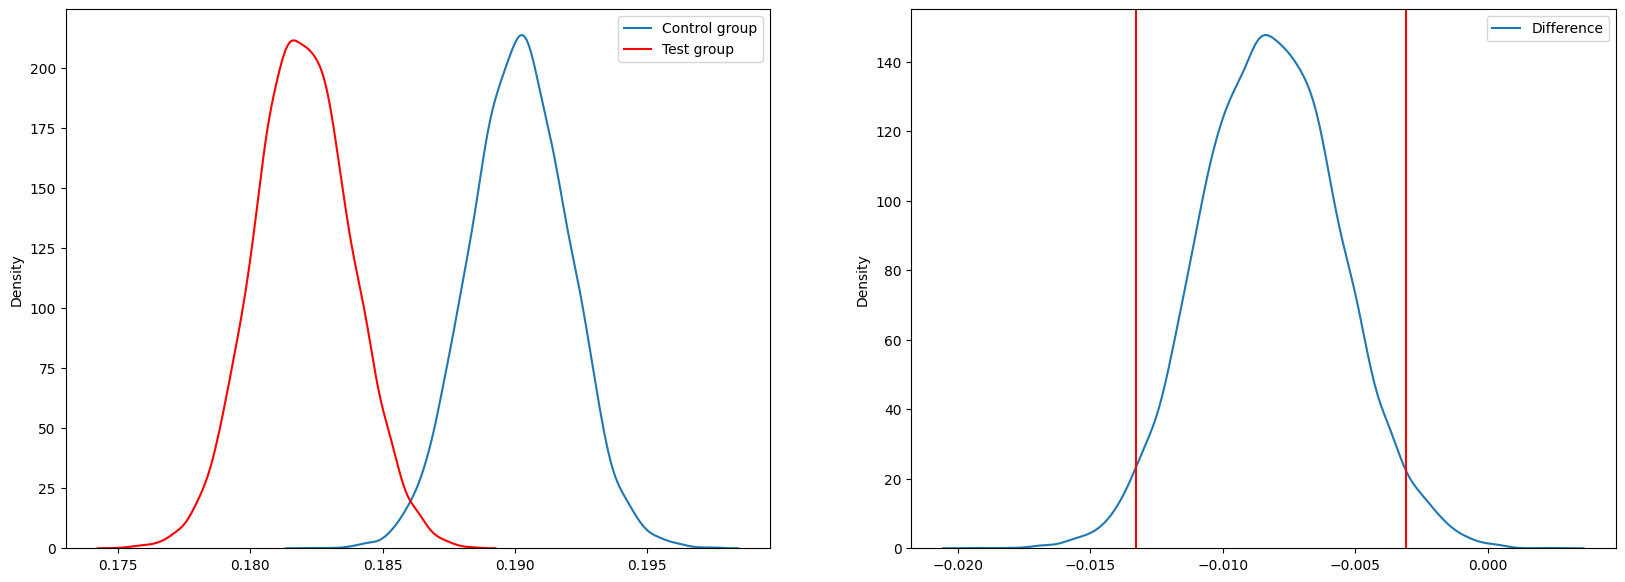

In [87]:
n = round(min(len(test_group_40), len(control_group_30))-500, -3)
b = 10000

bootstrap_test_group_40_rr7, bootstrap_control_group_30_rr7 = generate_subsamples(n, b, test_group_40['retention_7'], control_group_30['retention_7'])

bootstrap_mean_fucn(
    test_group_40['retention_7'],
    control_group_30['retention_7'],
    bootstrap_test_group_40_rr7,
    bootstrap_control_group_30_rr7
)

Value of metric changed by: -0.1218 (-1.3367 %)
95.0% confidence interval: (-0.2531, 0.0096) или (-2.7785%, 0.1050%)
The difference is statistically significant: False


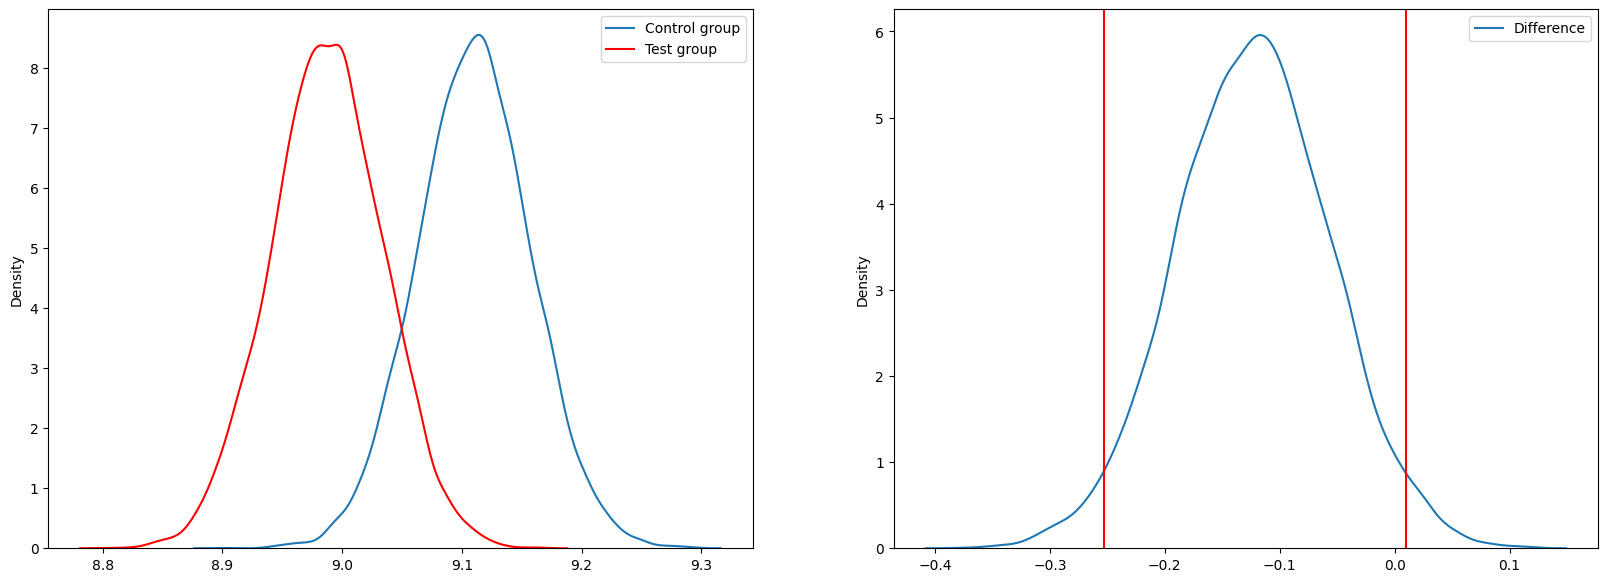

In [88]:
n = round(min(len(test_group_less_29), len(control_group_less_29))-500, -3)
b = 10000

bootstrap_test_group_less_29, bootstrap_control_group_less_29 = generate_subsamples(n, b, test_group_less_29['sum_gamerounds'], control_group_less_29['sum_gamerounds'])

bootstrap_mean_fucn(
    test_group_less_29['sum_gamerounds'],
    control_group_less_29['sum_gamerounds'],
    bootstrap_test_group_less_29,
    bootstrap_control_group_less_29
)

Value of metric changed by: -0.0040 (-1.7186 %)
95.0% confidence interval: (-0.0112, 0.0031) или (-4.7528%, 1.3156%)
The difference is statistically significant: False


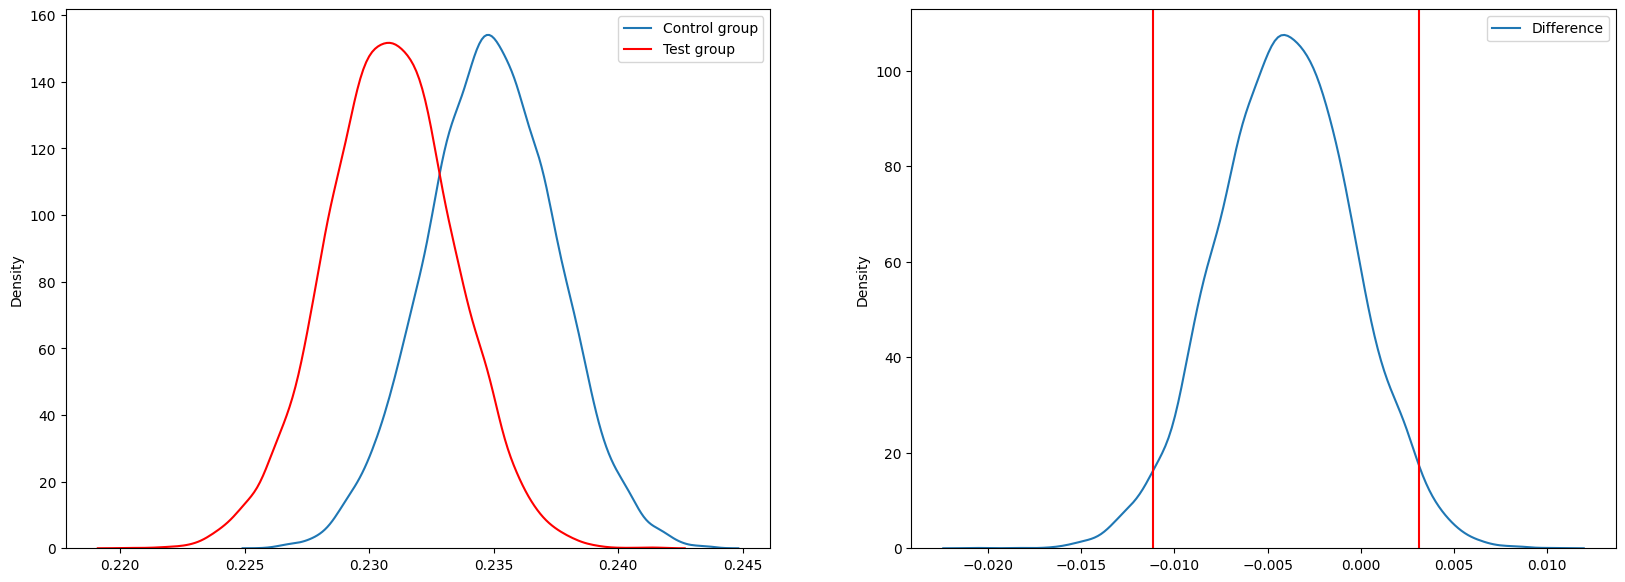

In [89]:
n = round(min(len(test_group_less_29), len(control_group_less_29))-500, -3)
b = 10000

bootstrap_test_group_less_29_rr1, bootstrap_control_group_less_29_rr1 = generate_subsamples(n, b, test_group_less_29['retention_1'], control_group_less_29['retention_1'])

bootstrap_mean_fucn(
    test_group_less_29['retention_1'],
    control_group_less_29['retention_1'],
    bootstrap_test_group_less_29_rr1,
    bootstrap_control_group_less_29_rr1
)

Value of metric changed by: -0.0027 (-6.6230 %)
95.0% confidence interval: (-0.0060, 0.0005) или (-14.5784%, 1.3323%)
The difference is statistically significant: False


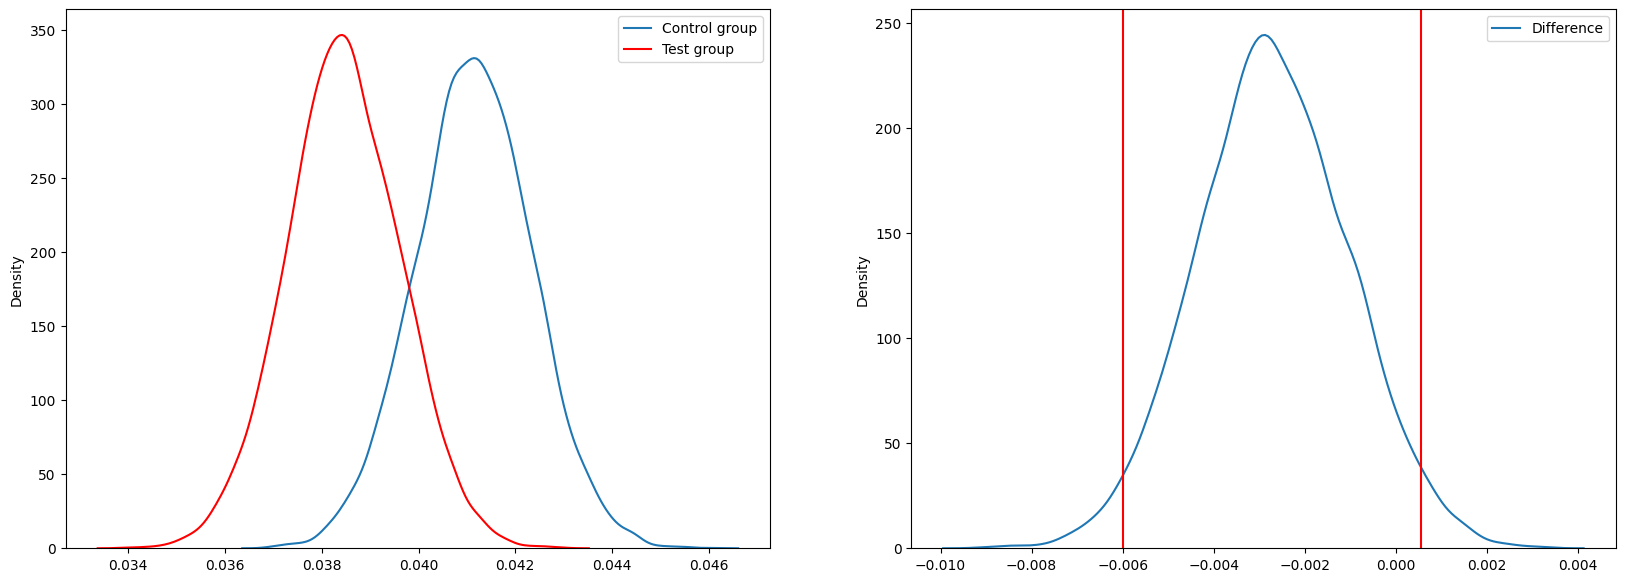

In [90]:
bootstrap_test_group_less_29_rr7, bootstrap_control_group_less_29_rr7 = generate_subsamples(n, b, test_group_less_29['retention_7'], control_group_less_29['retention_7'])

bootstrap_mean_fucn(
    test_group_less_29['retention_7'],
    control_group_less_29['retention_7'],
    bootstrap_test_group_less_29_rr7,
    bootstrap_control_group_less_29_rr7
)

Value of metric changed by: 1.2438 (2.3196 %)
95.0% confidence interval: (0.7162, 1.7713) или (1.3357%, 3.3034%)
The difference is statistically significant: True


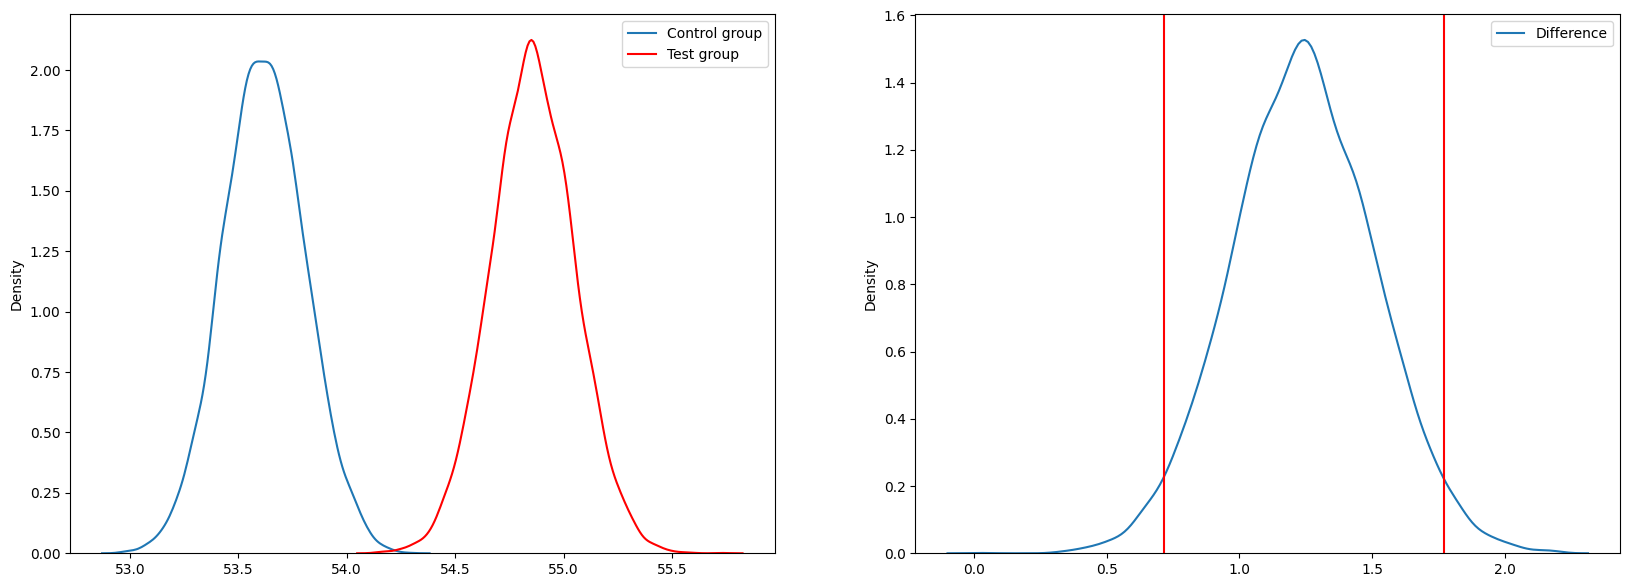

In [91]:
n = round(min(len(test_group_29_100), len(control_group_29_100))-50, -2)
b = 10000

bootstrap_test_group_29_100, bootstrap_control_group_29_100 = generate_subsamples(n, b, test_group_29_100['sum_gamerounds'], control_group_29_100['sum_gamerounds'])

bootstrap_mean_fucn(
    test_group_29_100['sum_gamerounds'],
    control_group_29_100['sum_gamerounds'],
    bootstrap_test_group_29_100,
    bootstrap_control_group_29_100
)

Value of metric changed by: 0.0025 (0.3448 %)
95.0% confidence interval: (-0.0096, 0.0147) или (-1.3039%, 1.9934%)
The difference is statistically significant: False


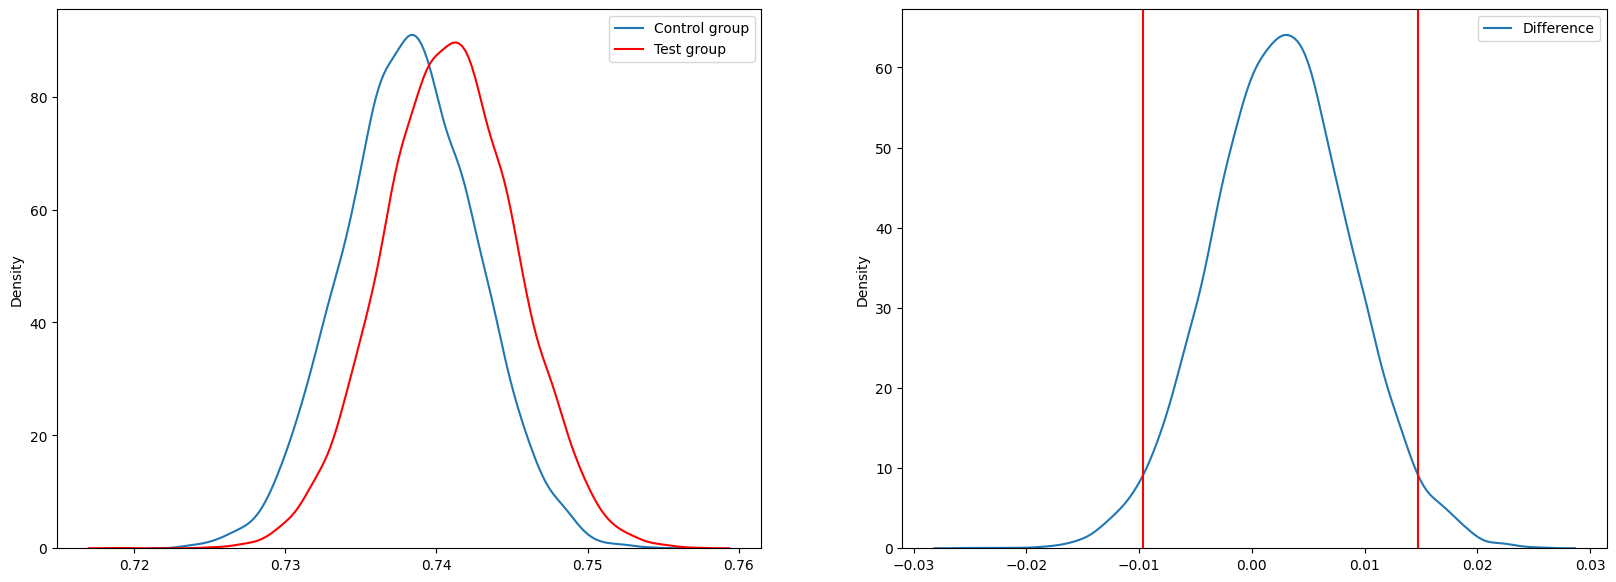

In [92]:
n = round(min(len(test_group_29_100), len(control_group_29_100))-500, -3)
b = 10000

bootstrap_test_group_29_100_rr1, bootstrap_control_group_29_100_rr1 = generate_subsamples(n, b, test_group_29_100['retention_1'], control_group_29_100['retention_1'])

bootstrap_mean_fucn(
    test_group_29_100['retention_1'],
    control_group_29_100['retention_1'],
    bootstrap_test_group_29_100_rr1,
    bootstrap_control_group_29_100_rr1
)

Value of metric changed by: -0.0231 (-8.3369 %)
95.0% confidence interval: (-0.0353, -0.0109) или (-12.7425%, -3.9312%)
The difference is statistically significant: True


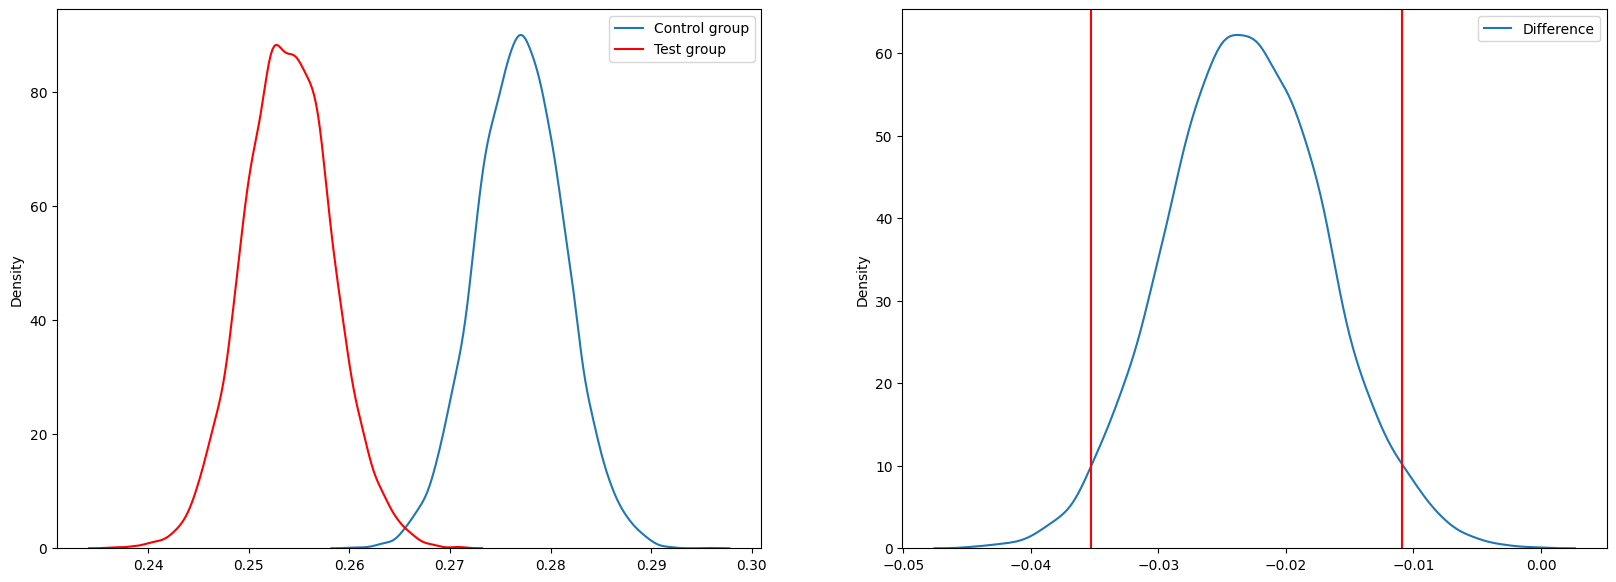

In [93]:
bootstrap_test_group_29_100_rr7, bootstrap_control_group_29_100_rr7 = generate_subsamples(n, b, test_group_29_100['retention_7'], control_group_29_100['retention_7'])

bootstrap_mean_fucn(
    test_group_29_100['retention_7'],
    control_group_29_100['retention_7'],
    bootstrap_test_group_29_100_rr7,
    bootstrap_control_group_29_100_rr7
)

Value of metric changed by: -2.1186 (-0.8845 %)
95.0% confidence interval: (-8.5361, 4.2990) или (-3.5636%, 1.7947%)
The difference is statistically significant: False


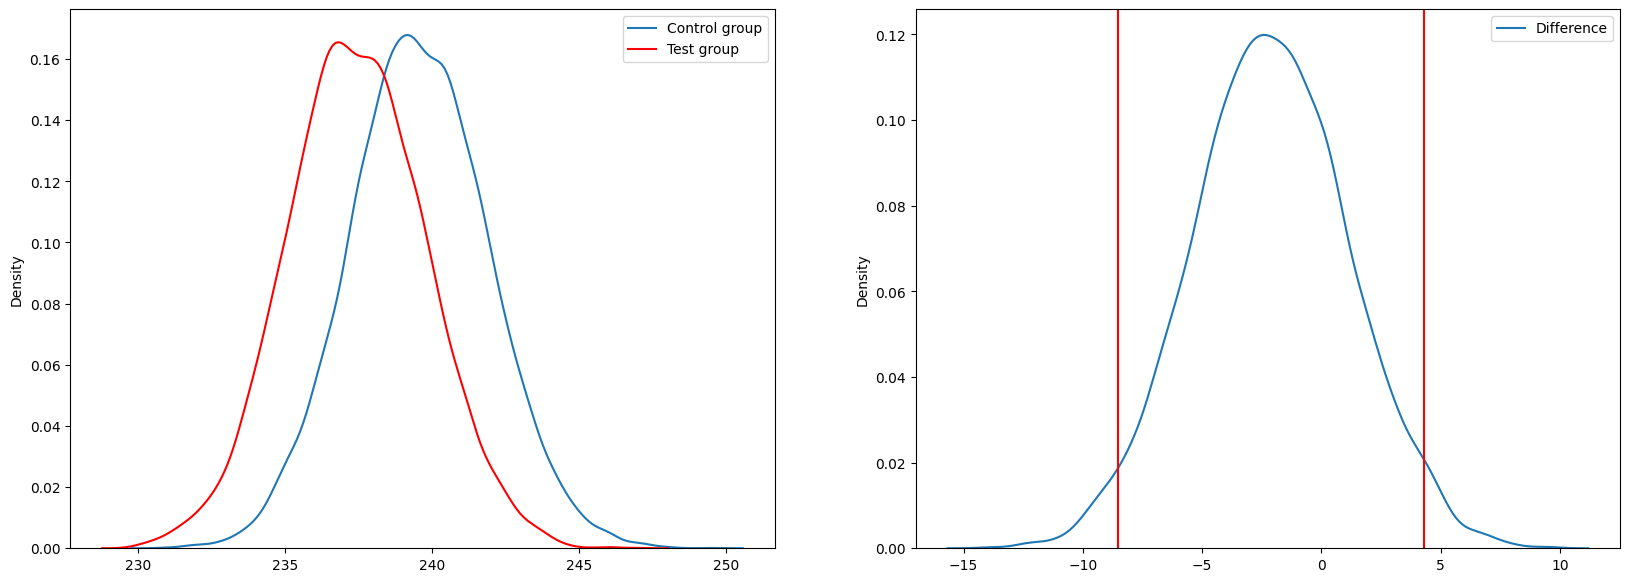

In [94]:
n = round(min(len(test_group_more_100), len(control_group_more_100))-50, -2)
b = 10000

bootstrap_test_group_more_100, bootstrap_control_group_more_100 = generate_subsamples(n, b, test_group_more_100['sum_gamerounds'], control_group_more_100['sum_gamerounds'])

bootstrap_mean_fucn(
    test_group_more_100['sum_gamerounds'],
    control_group_more_100['sum_gamerounds'],
    bootstrap_test_group_more_100,
    bootstrap_control_group_more_100
)

Value of metric changed by: -0.0044 (-0.4904 %)
95.0% confidence interval: (-0.0151, 0.0062) или (-1.6720%, 0.6912%)
The difference is statistically significant: False


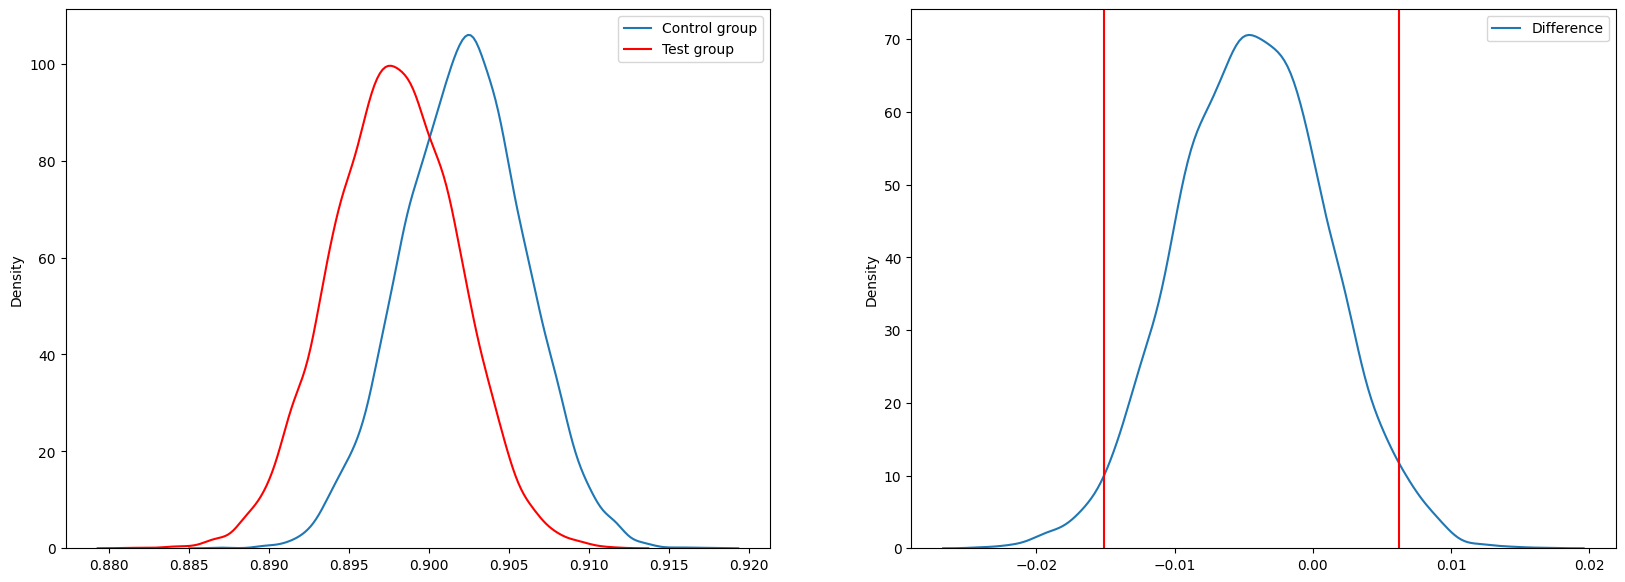

In [95]:
n = round(min(len(test_group_more_100), len(control_group_more_100))-500, -3)
b = 10000

bootstrap_test_group_more_100_rr1, bootstrap_control_group_more_100_rr1 = generate_subsamples(n, b, test_group_more_100['retention_1'], control_group_more_100['retention_1'])

bootstrap_mean_fucn(
    test_group_more_100['retention_1'],
    control_group_more_100['retention_1'],
    bootstrap_test_group_more_100_rr1,
    bootstrap_control_group_more_100_rr1
)

Value of metric changed by: -0.0014 (-0.1984 %)
95.0% confidence interval: (-0.0177, 0.0148) или (-2.4760%, 2.0792%)
The difference is statistically significant: False


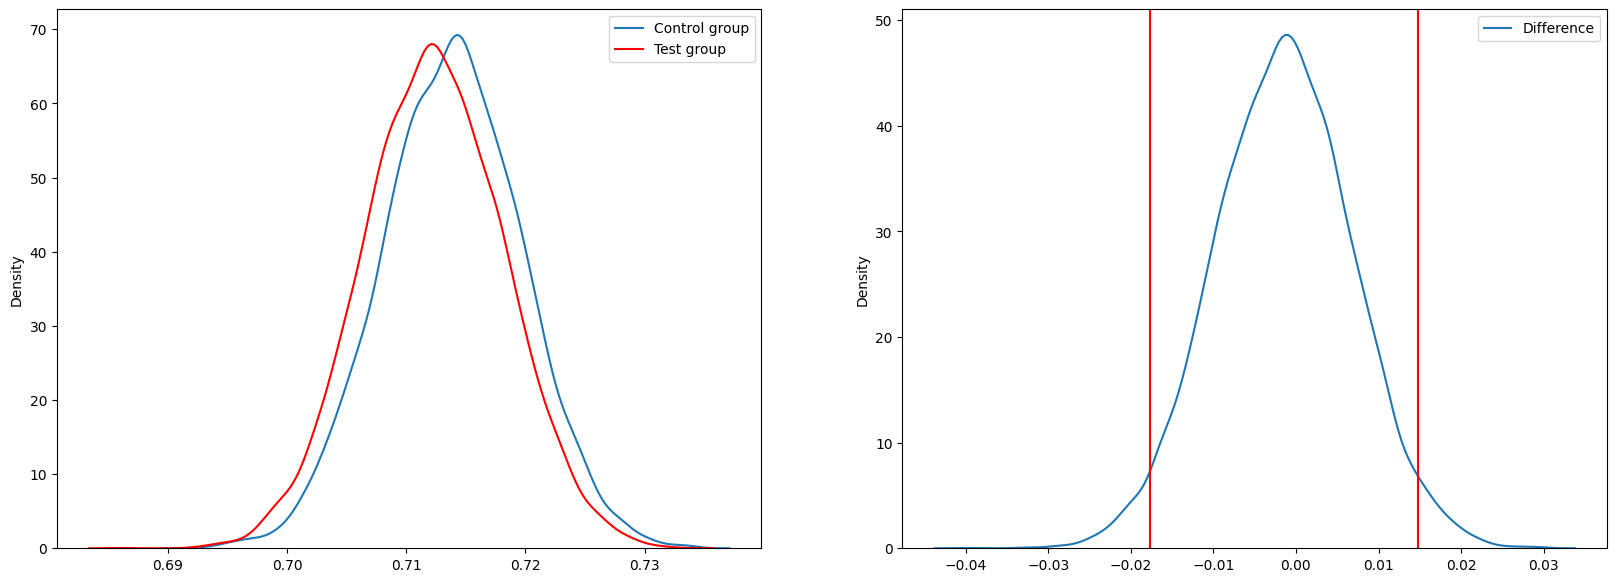

In [96]:
bootstrap_test_group_more_100_rr7, bootstrap_control_group_more_100_rr7 = generate_subsamples(n, b, test_group_more_100['retention_7'], control_group_more_100['retention_7'])

bootstrap_mean_fucn(
    test_group_more_100['retention_7'],
    control_group_more_100['retention_7'],
    bootstrap_test_group_more_100_rr7,
    bootstrap_control_group_more_100_rr7
)